In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(data=X_pca, columns=['Componente 1', 'Componente 2'])
df_pca['target'] = y

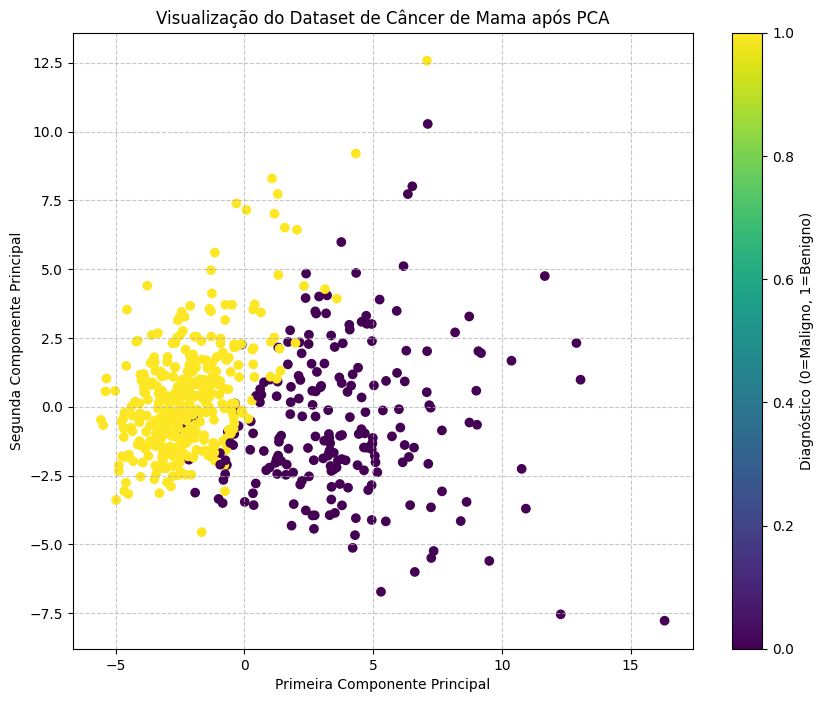

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_pca['Componente 1'], df_pca['Componente 2'], 
                     c=df_pca['target'], cmap='viridis')
plt.xlabel('Primeira Componente Principal')
plt.ylabel('Segunda Componente Principal')
plt.title('Visualização do Dataset de Câncer de Mama após PCA')
plt.colorbar(scatter, label='Diagnóstico (0=Maligno, 1=Benigno)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [5]:
def gaussian_pdf_2d(x, mean, sigma):
    x = np.array(x)
    mean = np.array(mean)
    diff = x - mean
    k = len(mean)
    exponent = -0.5 * diff.T @ np.linalg.inv(sigma) @ diff
    denom = np.sqrt((2 * np.pi) ** k * np.linalg.det(sigma))
    return np.exp(exponent) / denom


In [21]:
def get_stats(df, target_value):
    df_target = df[df['target'] == target_value]
    media = df_target[['Componente 1', 'Componente 2']].mean().values
    std = df_target[['Componente 1', 'Componente 2']].std().values
    return media, std

In [23]:
# Obtendo estatísticas para cada classe
media_t1, std_t1 = get_stats(df_pca, 1)
media_t0, std_t0 = get_stats(df_pca, 0)

# Criando matrizes de covariância (assumindo independência entre componentes)
sigma_t1 = np.diag(std_t1**2)
sigma_t0 = np.diag(std_t0**2)

# Testando para um ponto específico do dataset
ponto_teste = df_pca.iloc[0][['Componente 1', 'Componente 2']].values

# Calculando probabilidades
prob_t1 = gaussian_pdf_2d(ponto_teste, media_t1, sigma_t1)
prob_t0 = gaussian_pdf_2d(ponto_teste, media_t0, sigma_t0)

# Classificação bayesiana (assumindo probabilidades a priori iguais)
classe_predita = 1 if prob_t1 > prob_t0 else 0

In [27]:
# Obtendo estatísticas
media_t1, std_t1 = get_stats(df_pca, 1)
media_t0, std_t0 = get_stats(df_pca, 0)
sigma_t1 = np.diag(std_t1**2)
sigma_t0 = np.diag(std_t0**2)

# Calculando probabilidades para todos os pontos
df_pca['prob_1'] = df_pca.apply(lambda row: gaussian_pdf_2d(
    row[['Componente 1', 'Componente 2']].values, media_t1, sigma_t1), axis=1)
df_pca['prob_0'] = df_pca.apply(lambda row: gaussian_pdf_2d(
    row[['Componente 1', 'Componente 2']].values, media_t0, sigma_t0), axis=1)


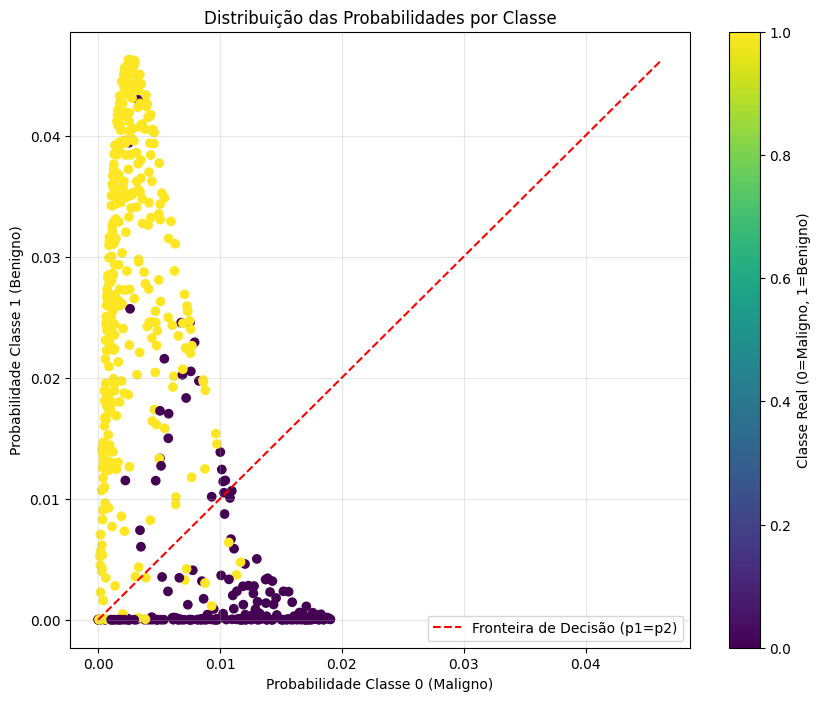

In [28]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_pca['prob_0'], df_pca['prob_1'], 
                     c=df_pca['target'], cmap='viridis')

# Linha de decisão p1=p2
max_prob = max(df_pca['prob_0'].max(), df_pca['prob_1'].max())
plt.plot([0, max_prob], [0, max_prob], 'r--', label='Fronteira de Decisão (p1=p2)')

plt.xlabel('Probabilidade Classe 0 (Maligno)')
plt.ylabel('Probabilidade Classe 1 (Benigno)')
plt.title('Distribuição das Probabilidades por Classe')
plt.colorbar(scatter, label='Classe Real (0=Maligno, 1=Benigno)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

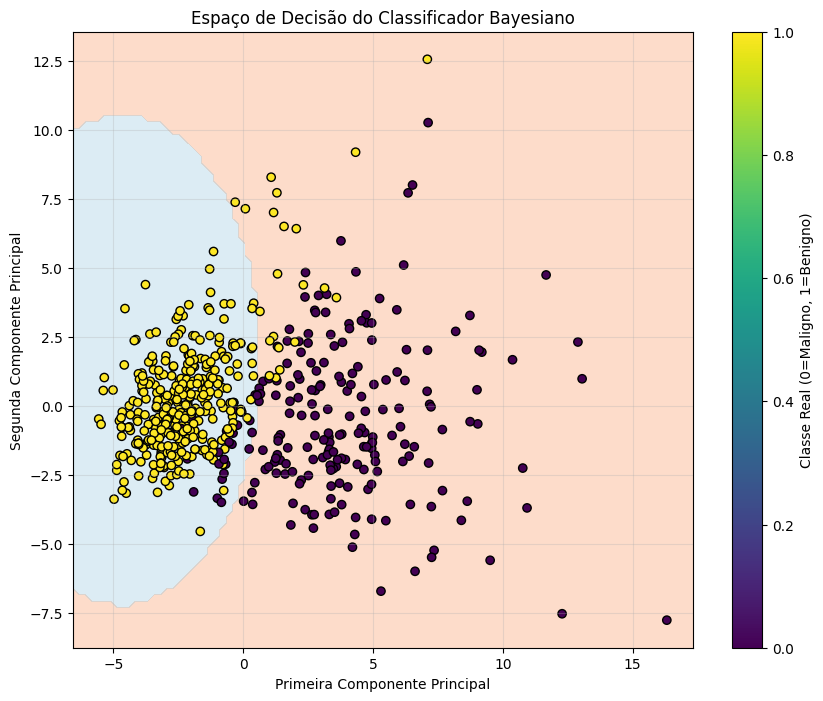

In [29]:
# Criando grade para visualização do espaço de predição
x_min, x_max = df_pca['Componente 1'].min() - 1, df_pca['Componente 1'].max() + 1
y_min, y_max = df_pca['Componente 2'].min() - 1, df_pca['Componente 2'].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Calculando probabilidades para cada ponto da grade
grid_points = np.c_[xx.ravel(), yy.ravel()]
prob1 = np.array([gaussian_pdf_2d(point, media_t1, sigma_t1) for point in grid_points])
prob0 = np.array([gaussian_pdf_2d(point, media_t0, sigma_t0) for point in grid_points])
Z = (prob1 > prob0).reshape(xx.shape)

# Plotando
plt.figure(figsize=(10, 8))

# Plotando região de decisão
plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')

# Plotando pontos originais
scatter = plt.scatter(df_pca['Componente 1'], df_pca['Componente 2'], 
                     c=df_pca['target'], cmap='viridis', 
                     edgecolor='black', linewidth=1)

plt.xlabel('Primeira Componente Principal')
plt.ylabel('Segunda Componente Principal')
plt.title('Espaço de Decisão do Classificador Bayesiano')
plt.colorbar(scatter, label='Classe Real (0=Maligno, 1=Benigno)')
plt.grid(True, alpha=0.3)
plt.show()